In [1]:
import numpy as np
import matplotlib.pyplot as plt
import aopy
import os
import pandas as pds
# from db import dbfunctions as db
from ipywidgets import interactive, widgets
import scipy
import h5py
from tqdm.auto import tqdm 
import seaborn as sn
import sklearn
from sklearn.decomposition import PCA, FactorAnalysis
from itertools import compress
import multiprocessing as mp
import time
import math
from scipy.fft import fft
import glob
from datetime import date

# Set parameters

In [42]:
align_idx = 2

# Site 45
# flash_teid = 14138
# mc_teid = 14139

# Site 98
# flash_teid = 14115
# mc_teid = 14116

# Site 30
# flash_teid = 13271
# mc_teid = 13272

# Site 120
flash_teid = 13255
mc_teid = 13256

# Site 9
# flash_teid = 13238
# mc_teid = 13239

# Site 11
# flash_teid = 10824 #: bottom
# flash_teid = 10825 # Long column
# mc_teid = 10828

# Site 40
# flash_teid = 10811
# mc_teid = 10812

In [43]:
# Paths
save_figs = True
data_path_preproc = '/media/moor-data/preprocessed.new/'
data_path_raw = '/media/moor-data/raw/neuropixels/'
base_save_dir = "/media/moor-data/results/Ryan/neuropixel_targeting/ap_band_power_plots"

# General data parameters
subject = 'beignet'
task_coords = 'yzx'
task_perturb = None
task_rotation = 0

# Task event code definitions
task_codes = aopy.data.bmi3d.load_bmi3d_task_codes()

# Trial selection parameters
trial_filter = lambda t: CENTER_TARGET_OFF in t

# Neuropixel data parameters
implant_name = ['NP_Insert72', 'NP_Insert137']
start_date = '2023-07-13'
end_date = date.today()
elec_config = 'bottom'
spike_bin_width_mc = 0.01 #[s]
smooth_width = 150
smooth_nstd = 3

# Task data selection parameters
tbefore = 0.25
tafter = .75
task_events = ['TARGET ONSET', 'GO CUE', 'REWARD']
task_event_to_align = task_events[align_idx]
samplerate_dwns = 10000 #[hz]

# Visualization parameters
colors = sn.color_palette(n_colors=9)

if task_event_to_align == 'TARGET ONSET':
    event_label = 'hold_start_time'
elif task_event_to_align == 'GO CUE':
    event_label='go_cue_time'
elif task_event_to_align == 'REWARD':
    event_label='reach_end_time'

In [4]:
# flash_entries = aopy.data.db.get_task_entries(subject__name=subject, task__name='manual control', date=(start_date, end_date))
# flash_entries = [fe for fe in flash_entries if 'neuropixel_port1_drive_type' in fe.task_params and fe.task_params['neuropixel_port1_drive_type'] in implant_name and fe.entry_name == 'flash']

In [5]:
# # Load neuropixel center-out task data
# # bad_tes = [13152, 13153, 13154, 13155, 13156, 13272]
# bad_tes = [13152, 13153, 13154, 13155, 13156,13102, 13272, 12290, 12291] # Also remove recording at site 48
# # bad_tes = [13102,13152, 13153, 13154, 13155, 13156, 13272, 9940, 9958, 10812, 10820, 12290, 12291]
# mc_entries =  db.get_task_entries(subject__name=subject, task__name='manual control', date=(start_date, end_date))
# mc_entries = [me for me in mc_entries if 'neuropixel_port1_drive_type' in me.task_params and me.task_params['neuropixel_port1_drive_type'] in implant_name
#              and me.task_params['rotation']==task_coords and me.entry_name != 'flash']

# # Remove bad TE IDs
# mc_entries = [me for me in mc_entries if me.id not in bad_tes]
# dates = np.unique([me.date.date() for me in mc_entries])

# print(mc_entries, '\n','\n', dates)

# Flash data

In [6]:
# Align raw data to flash
flash_entry = aopy.data.db.lookup_sessions(id=flash_teid)[0]

# Load data
te_id = flash_entry.id
date = flash_entry.date
print(te_id, date)
data_folder = f"{date}_Neuropixel_{subject}_te{te_id}"
rawdata_flash, metadata_flash = aopy.data.neuropixel.load_neuropixel_data(data_path_raw, data_folder, 'ap')
preproc_filename_flash = aopy.data.get_preprocessed_filename(subject, te_id, date, 'lfp')
preproc_filename_flash_ap = aopy.data.get_preprocessed_filename(subject, te_id, date, 'ap')
ap_data_flash = aopy.data.load_hdf_group(os.path.join(data_path_preproc, subject), preproc_filename_flash_ap, 'ap')
lfp_data_flash = aopy.data.load_hdf_group(os.path.join(data_path_preproc, subject), preproc_filename_flash, 'lfp')
lfp_metadata_flash = aopy.data.load_hdf_group(os.path.join(data_path_preproc, subject), preproc_filename_flash, 'metadata')

13255 2024-01-04


In [7]:
flash_dwns = aopy.precondition.base.downsample(np.array(rawdata_flash.samples), metadata_flash['sample_rate'], samplerate_dwns)
ap_timestamps,_ = aopy.preproc.base.interp_timestamps2timeseries(lfp_data_flash['sync_timestamp'], lfp_data_flash['sync_timestamp'], samplerate=samplerate_dwns) # upsample lfp timestamps to AP

In [8]:
df_flash = aopy.data.bmi3d.tabulate_behavior_data_flash(data_path_preproc, [subject], [te_id], [date], metadata=['neuropixel_port1_site'])
talign_times_flash, talign_idx_flash = aopy.preproc.base.trial_align_times(ap_timestamps, df_flash['flash_start_time'][:-1], tbefore, tafter)
ks_unit_depth = [ap_data_flash['pos'][unit_name][1] for unit_name in list(ap_data_flash['pos'].keys())]

  0%|          | 0/1 [00:00<?, ?it/s]

In [9]:
# Trial align 
ntrial_time = np.min([len(idx) for idx in talign_idx_flash])
nflash_trials = len(talign_times_flash)
nch = flash_dwns.shape[1]
flash_align = np.zeros((ntrial_time, nflash_trials, nch))

for itrial, trial_idx in enumerate(tqdm(talign_idx_flash)):
    flash_align[:,itrial,:] = flash_dwns[trial_idx,:]*metadata_flash['bit_volts']

  0%|          | 0/99 [00:00<?, ?it/s]

In [10]:
# Center flashs 
flash_align_center = flash_align - np.mean(flash_align, axis=(0,1))
unique_values, unique_idx = np.unique(metadata_flash['ypos'], return_index=True)

# Average neighboring channels
flash_align_center_mean = []
for ypos in tqdm(unique_values):
    ch_mask = metadata_flash['ypos']==ypos
    flash_align_center_mean.append(np.mean(flash_align_center[:,:,ch_mask], axis=2).T)

flash_align_center_mean = np.array(flash_align_center_mean)

  0%|          | 0/384 [00:00<?, ?it/s]

In [11]:
# Plot neuron pos
bins = 15
ks_unit_depth = [ap_data_flash['pos'][unit_name][1] for unit_name in list(ap_data_flash['pos'].keys())]
unit_dist, bin_edges = np.histogram(ks_unit_depth, bins=bins)

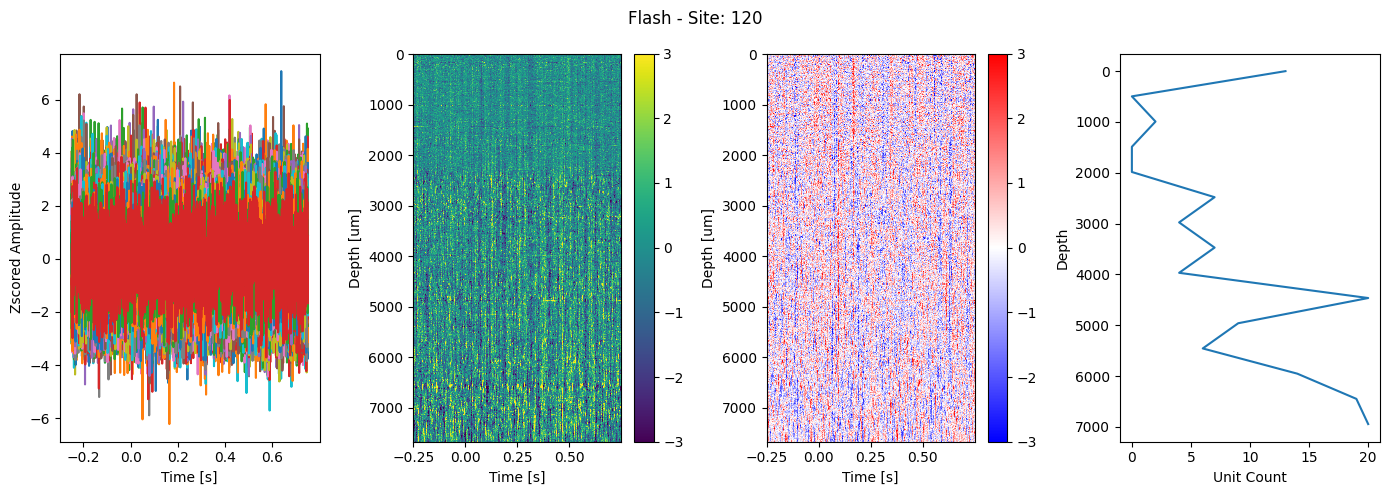

In [12]:
trial_time_axis_flash = (np.arange(ntrial_time)/samplerate_dwns) - tbefore

fig, ax = plt.subplots(1,4,figsize=(14,5))
ax[0].plot(trial_time_axis_flash, scipy.stats.zscore(np.mean(flash_align_center_mean, axis=1), axis=1).T)
ax[0].set(xlabel='Time [s]', ylabel='Zscored Amplitude')

# ax1 = ax[1].pcolor(trial_time_axis_flash, metadata_flash['ypos'], np.mean(flash_align_center, axis=1).T)
map1 = ax[1].pcolor(trial_time_axis_flash,np.max(unique_values) - np.unique(unique_values), np.mean(flash_align_center_mean, axis=1), vmin=-3, vmax=3)
ax[1].invert_yaxis()
ax[1].set(xlabel='Time [s]', ylabel='Depth [um]')
cb = plt.colorbar(map1)

map1 = ax[2].pcolor(trial_time_axis_flash, np.max(unique_values) - np.unique(unique_values), scipy.stats.zscore(np.mean(flash_align_center_mean, axis=1), axis=1), cmap='bwr', vmin=-3, vmax=3)
ax[2].invert_yaxis()
ax[2].set(xlabel='Time [s]', ylabel='Depth [um]')
cb = plt.colorbar(map1)

ax[3].plot(unit_dist, np.max(unique_values) - bin_edges[:-1]-np.diff(bin_edges)[0])
ax[3].invert_yaxis()
ax[3].set(xlabel='Unit Count', ylabel='Depth')

site = df_flash['neuropixel_port1_site'][0]
plt.suptitle(f'Flash - Site: {site}')

fig.tight_layout()
aopy.visualization.savefig(base_save_dir, f"{subject}_Site{site}_Flash_raw{flash_teid}.png") 


In [13]:
# Filter
bands = [(300,3000)]
n = .01
w = 250
step_size = 0.001
n,p,k = aopy.precondition.base.convert_taper_parameters(n,w)
print(n, p, k)
start = time.time()
spec = []
for itr in tqdm(range(flash_align_center_mean.shape[1])):
    t, spec_temp = aopy.analysis.base.get_bandpower_feats(flash_align_center_mean[:,itr,:].T, samplerate_dwns, bands=bands, log=True, ref=True, 
                                                 n=n, p=p, k=k, fk=bands[0][1], step = step_size)
    spec.append(spec_temp)
print(time.time() - start)
spec = np.array(spec)

0.01 2.5 4


  0%|          | 0/99 [00:00<?, ?it/s]

348.6061224937439


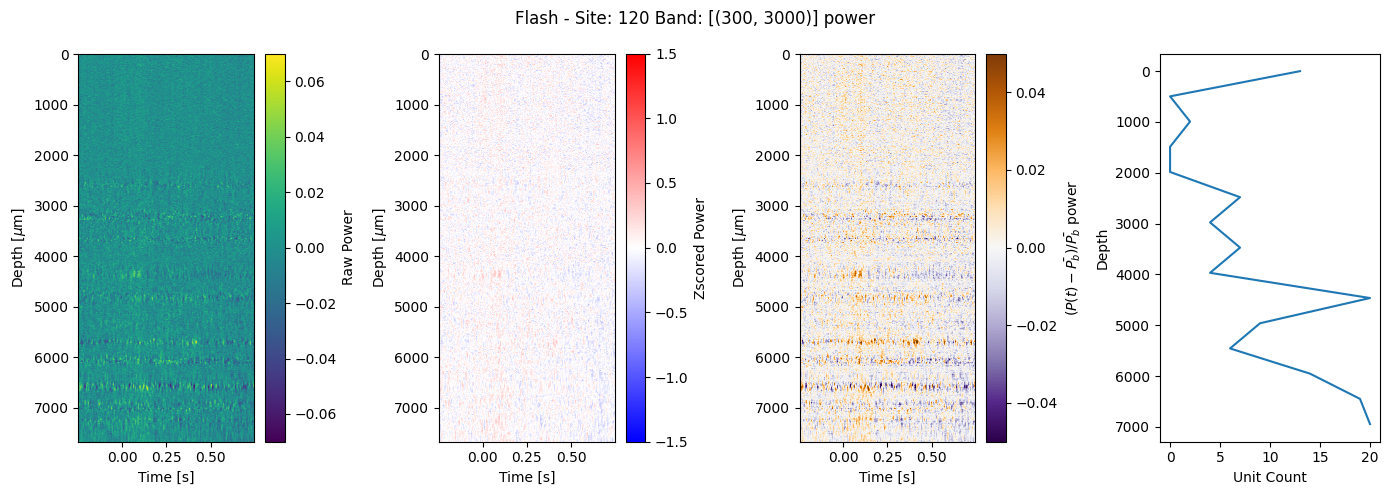

In [14]:
fig, ax = plt.subplots(1,4,figsize=(14,5))
unique_values, unique_idx = np.unique(metadata_flash['ypos'], return_index=True)
map0 = ax[0].pcolor(t-tbefore, np.max(unique_values) - unique_values, (np.mean(spec, axis=0) - np.mean(np.mean(spec, axis=0), axis=0)).T, vmin=-0.07, vmax=0.07)
cb = plt.colorbar(map0, label='Raw Power')
ax[0].invert_yaxis()
ax[0].set(xlabel='Time [s]', ylabel='Depth [$\mu$m]')
             
map1 = ax[1].pcolor(t-tbefore,np.max(unique_values) - unique_values, np.mean(((spec - np.mean(spec,axis=(0,1)))/np.std(spec, axis=(0,1))), axis=0).T, cmap='bwr', vmin=-1.5, vmax=1.5)
ax[1].invert_yaxis()
ax[1].set(xlabel='Time [s]', ylabel='Depth [$\mu$m]')
cb = plt.colorbar(map1, label='Zscored Power')

bidx1 = 0
bidx2 = np.where((t-tbefore)>=0)[0][0]
map2 = ax[2].pcolor(t-tbefore, np.max(unique_values) - unique_values, ((np.mean(spec, axis=0) - np.mean(spec[:,bidx1:bidx2,:], axis=(0,1)))/np.mean(spec[:,bidx1:bidx2,:], axis=(0,1))).T, cmap='PuOr_r', vmin=-0.05, vmax=0.05)
cb = plt.colorbar(map2, label=r'$(P(t) - \bar{P_b})/\bar{P_b}$ power')
ax[2].set(xlabel='Time [s]', ylabel='Depth [$\mu$m]')
ax[2].invert_yaxis()

ax[3].plot(unit_dist, np.max(unique_values) - bin_edges[:-1]-np.diff(bin_edges)[0])
ax[3].invert_yaxis()
ax[3].set(xlabel='Unit Count', ylabel='Depth')

site = df_flash['neuropixel_port1_site'][0]
plt.suptitle(f'Flash - Site: {site} Band: {bands} power')

fig.tight_layout()
aopy.visualization.savefig(base_save_dir, f"{subject}_Site{site}_Flash_power{flash_teid}.png") 

# Load MC data

In [63]:
# ks_folder_name = f"{date}_Neuropixel_ks_{subject}_site{site}_{elec_config}_port1"
# # (f"{data_path_preproc}kilosort/{ks_folder_name}/kilosort_output/whitening_mat_inv.npy")
# whitening_mat_inv = np.load(f"{data_path_preproc}kilosort/{ks_folder_name}/kilosort_output/whitening_mat_inv.npy")

In [ ]:
# print(whitening_mat_inv.shape, rawdata_mc.samples.shape)
# unwhitened_data = rawdata_mc.samples @ whitening_mat_inv

(384, 384) (80668092, 384)


In [15]:
aopy.utils.release_memory_limit()

In [16]:
mc_entry = aopy.data.db.lookup_sessions(id=mc_teid)[0]

In [17]:
# Load data
te_id_mc = mc_entry.id
date_mc = mc_entry.date
data_folder_mc = f"{date_mc}_Neuropixel_{subject}_te{te_id_mc}"
rawdata_mc, metadata_mc = aopy.data.neuropixel.load_neuropixel_data(data_path_raw, data_folder_mc, 'ap')
preproc_filename_mc = aopy.data.get_preprocessed_filename(subject, te_id_mc, date_mc, 'lfp')
lfp_data_mc = aopy.data.load_hdf_group(os.path.join(data_path_preproc, subject), preproc_filename_mc, 'lfp')
lfp_metadata_mc = aopy.data.load_hdf_group(os.path.join(data_path_preproc, subject), preproc_filename_mc, 'metadata')

In [18]:
preproc_filename_mc_ap = aopy.data.get_preprocessed_filename(subject, te_id_mc, date_mc, 'ap')
ap_data_mc = aopy.data.load_hdf_group(os.path.join(data_path_preproc, subject), preproc_filename_mc_ap, 'ap')

In [19]:
mc_dwns = aopy.precondition.base.downsample(np.array(rawdata_mc.samples), metadata_mc['sample_rate'], samplerate_dwns)
ap_timestamps,_ = aopy.preproc.base.interp_timestamps2timeseries(lfp_data_mc['sync_timestamp'], lfp_data_mc['sync_timestamp'], samplerate=samplerate_dwns) # upsample lfp timestamps to AP

In [44]:
print(event_label, task_event_to_align)
df_mc = aopy.data.bmi3d.tabulate_behavior_data_center_out(data_path_preproc, [subject], [te_id_mc], [date_mc], metadata=['neuropixel_port1_site'])
talign_times_mc, talign_idx_mc = aopy.preproc.base.trial_align_times(ap_timestamps, np.array(df_mc[event_label])[df_mc['reward']], tbefore, tafter)

reach_end_time REWARD


  0%|          | 0/1 [00:00<?, ?it/s]

In [45]:
# Plot neuron pos
bins = 15
ks_unit_depth_mc = [ap_data_mc['pos'][unit_name][1] for unit_name in list(ap_data_mc['pos'].keys())]
unit_dist_mc, bin_edges_mc = np.histogram(ks_unit_depth_mc, bins=bins)

In [46]:
# Trial align 
ntrial_time = np.min([len(idx) for idx in talign_idx_mc])
nmc_trials = len(talign_times_mc)
nch = mc_dwns.shape[1]
mc_align = np.zeros((ntrial_time, nmc_trials, nch))

for itrial, trial_idx in enumerate(tqdm(talign_idx_mc)):
    mc_align[:,itrial,:] = mc_dwns[trial_idx,:]*metadata_mc['bit_volts']

  0%|          | 0/1024 [00:00<?, ?it/s]

In [47]:
# Center  
mc_align_center = mc_align - np.mean(mc_align, axis=(0,1))

# Average neighboring channels
mc_align_center_mean = []
for ypos in tqdm(np.unique(metadata_mc['ypos'])):
    ch_mask = metadata_mc['ypos']==ypos
    mc_align_center_mean.append(np.mean(mc_align_center[:,:,ch_mask], axis=2).T)

mc_align_center_mean = np.array(mc_align_center_mean)

  0%|          | 0/192 [00:00<?, ?it/s]

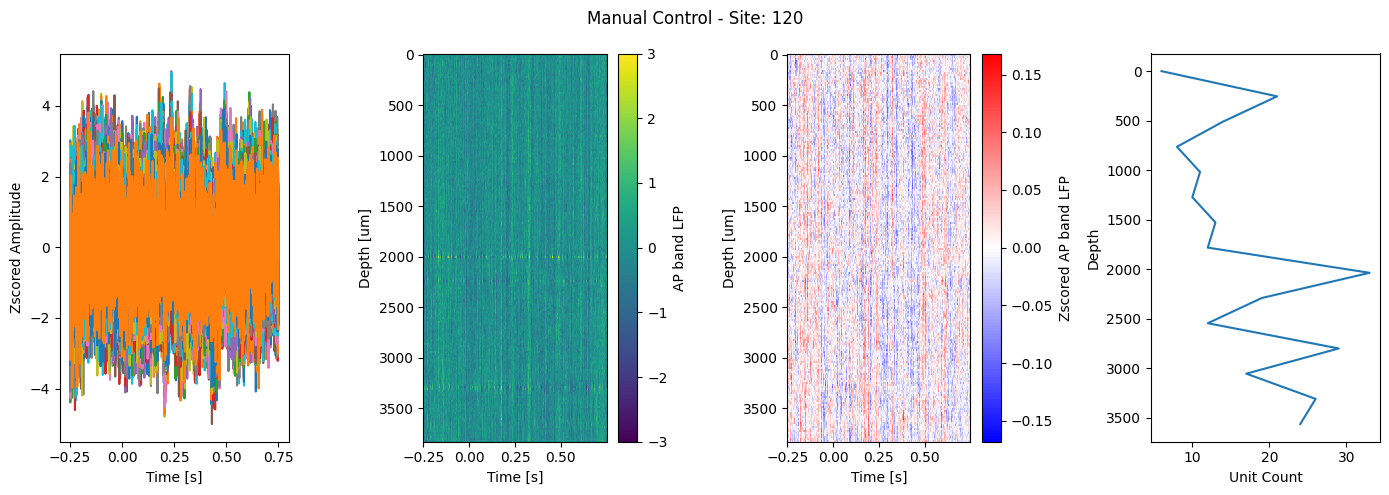

In [48]:
trial_time_axis = (np.arange(ntrial_time)/samplerate_dwns) - tbefore

fig, ax = plt.subplots(1,4,figsize=(14,5))
ax[0].plot(trial_time_axis, scipy.stats.zscore(np.mean(mc_align_center_mean, axis=1), axis=1).T)
ax[0].set(xlabel='Time [s]', ylabel='Zscored Amplitude')

# ax1 = ax[1].pcolor(trial_time_axis_flash, metadata_flash['ypos'], np.mean(flash_align_center, axis=1).T)
map1 = ax[1].pcolor(trial_time_axis, np.max(np.unique(metadata_mc['ypos'])) - np.unique(metadata_mc['ypos']), np.mean(mc_align_center_mean, axis=1), vmin=-3, vmax=3)
ax[1].invert_yaxis()
ax[1].set(xlabel='Time [s]', ylabel='Depth [um]')
cb = plt.colorbar(map1, label='AP band LFP')

map1 = ax[2].pcolor(trial_time_axis, np.max(np.unique(metadata_mc['ypos'])) - np.unique(metadata_mc['ypos']), np.mean(((mc_align_center_mean - np.mean(mc_align_center_mean,axis=(1,2))[:,None,None])/np.std(mc_align_center_mean, axis=(1,2))[:,None,None]), axis=1), cmap='bwr')
ax[2].invert_yaxis()
ax[2].set(xlabel='Time [s]', ylabel='Depth [um]')
cb = plt.colorbar(map1, label='Zscored AP band LFP')

ax[3].plot(unit_dist_mc, np.max(metadata_mc['ypos']) - bin_edges_mc[:-1]-np.diff(bin_edges_mc)[0])
ax[3].invert_yaxis()
ax[3].set(xlabel='Unit Count', ylabel='Depth')

site = df_mc['neuropixel_port1_site'][0]
plt.suptitle(f'Manual Control - Site: {site}')

fig.tight_layout()
aopy.visualization.savefig(base_save_dir, f"{subject}_Site{site}_MC_raw_{task_event_to_align}{mc_teid}.png") 

In [49]:
# Filter
bands = [(300,3000)]
# n = .1
# w = 25
# step_size = 0.02
# n,p,k = aopy.precondition.base.convert_taper_parameters(n,w)
# print(n, p, k)
start = time.time()
spec_mc = []
for itr in tqdm(range(mc_align_center_mean.shape[1])):
    t, spec_temp = aopy.analysis.base.get_bandpower_feats(mc_align_center_mean[:,itr,:].T, samplerate_dwns, bands=bands, log=True, ref=True, 
                                                 n=n, p=p, k=k, fk=bands[0][1], step = step_size)
    spec_mc.append(spec_temp)
print(time.time() - start)
spec_mc = np.array(spec_mc)

  0%|          | 0/1024 [00:00<?, ?it/s]

1794.9364778995514


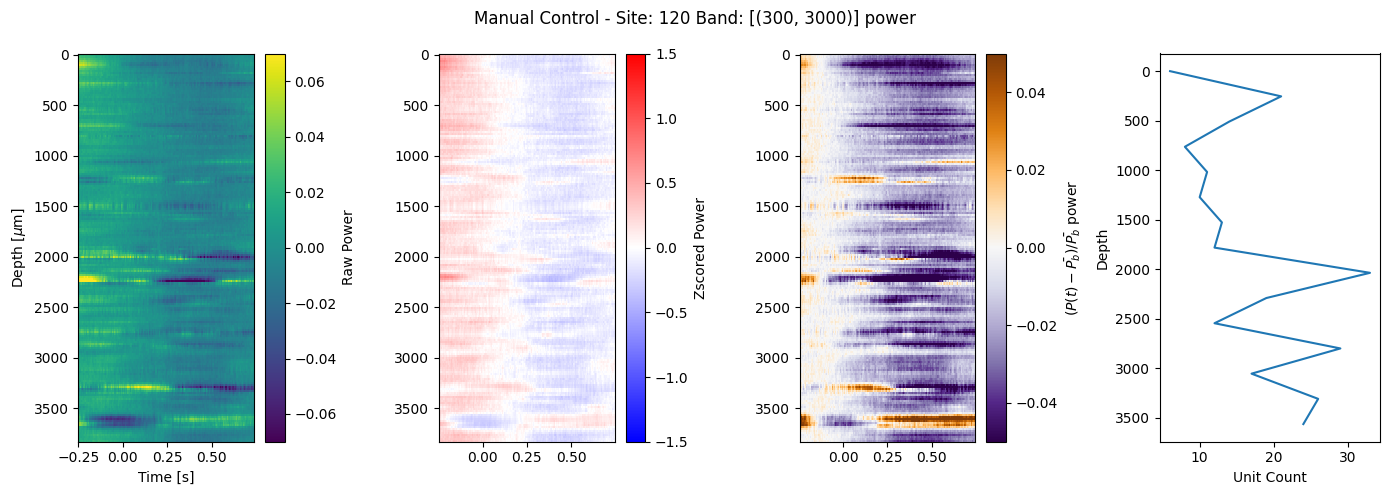

In [50]:
fig, ax = plt.subplots(1,4,figsize=(14,5))
map0 = ax[0].pcolor(np.arange(spec_mc.shape[1])*step_size-tbefore, np.max(np.unique(metadata_mc['ypos'])) - np.unique(metadata_mc['ypos']), (np.mean(spec_mc, axis=0) - np.mean(np.mean(spec_mc, axis=0), axis=0)).T, vmin=-0.07, vmax=0.07)
cb = plt.colorbar(map0, label='Raw Power')
ax[0].invert_yaxis()
ax[0].set(xlabel='Time [s]', ylabel='Depth [$\mu$m]')
             
map1 = ax[1].pcolor(t-tbefore, np.max(np.unique(metadata_mc['ypos'])) - np.unique(metadata_mc['ypos']), np.mean(((spec_mc - np.mean(spec_mc,axis=(0,1)))/np.std(spec_mc, axis=(0,1))), axis=0).T, cmap='bwr', vmin=-1.5, vmax=1.5)
ax[1].invert_yaxis()
cb = plt.colorbar(map1, label='Zscored Power')

# Mean subtracted power
bidx1 = 0
bidx2 = np.where((t-tbefore)>=0)[0][0]
map2 = ax[2].pcolor(t-tbefore,  np.max(np.unique(metadata_mc['ypos'])) - np.unique(metadata_mc['ypos']), ((np.mean(spec_mc, axis=0) - np.mean(spec_mc[:,bidx1:bidx2,:], axis=(0,1)))/np.mean(spec_mc[:,bidx1:bidx2,:], axis=(0,1))).T, cmap='PuOr_r', vmin=-0.05, vmax=0.05)
cb = plt.colorbar(map2, label=r'$(P(t) - \bar{P_b})/\bar{P_b}$ power')
ax[2].invert_yaxis()

ax[3].plot(unit_dist_mc, np.max(metadata_mc['ypos']) - bin_edges_mc[:-1]-np.diff(bin_edges_mc)[0])
ax[3].invert_yaxis()
ax[3].set(xlabel='Unit Count', ylabel='Depth')

site = df_mc['neuropixel_port1_site'][0]
plt.suptitle(f'Manual Control - Site: {site} Band: {bands} power')

fig.tight_layout()
aopy.visualization.savefig(base_save_dir, f"{subject}_Site{site}_MC_power_{task_event_to_align}{mc_teid}.png") 

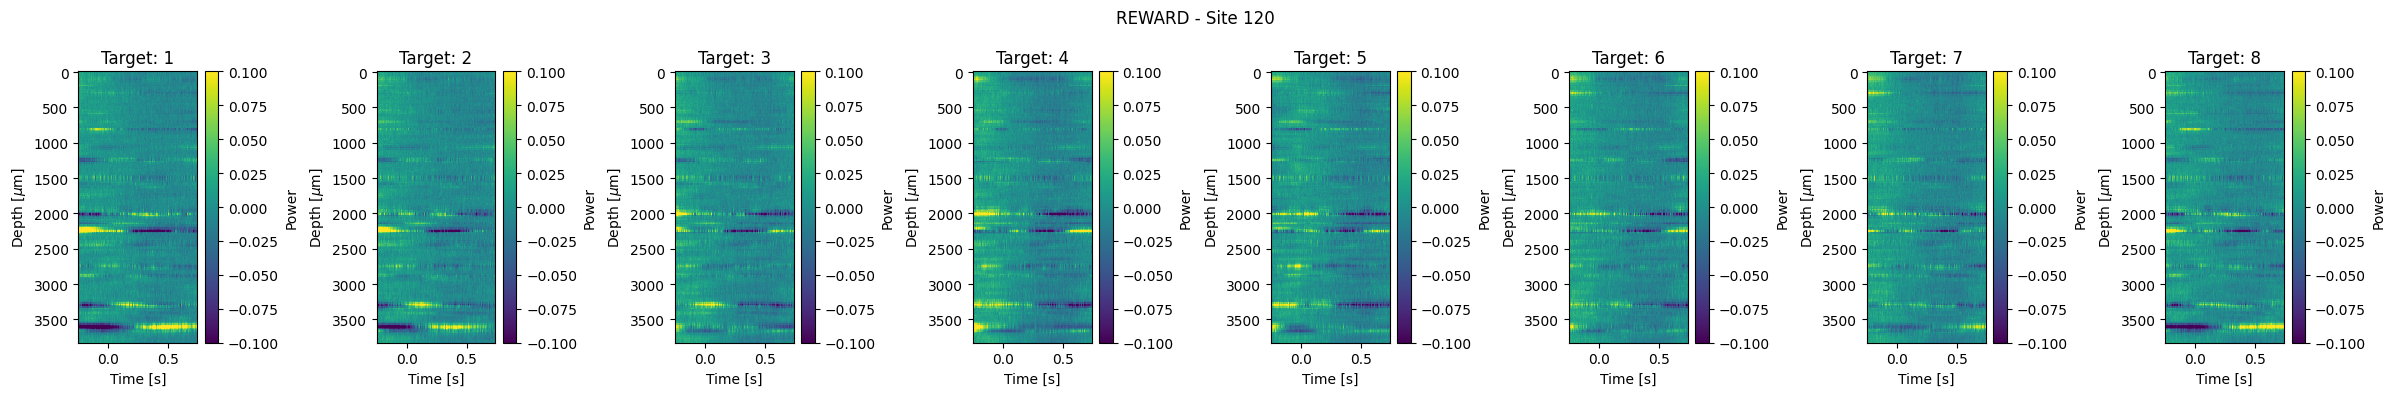

In [51]:
# Target specific figures. 
ntargets = len(np.unique(df_mc['target_idx']))-1
fig, ax = plt.subplots(1,ntargets,figsize=(ntargets*3,4))
for itarget in range(ntargets):
    target_idx_plot = np.where(np.array(df_mc['target_idx'][df_mc['reward']]) == (itarget+1))[0]
    temp_map = ax[itarget].pcolor(np.arange(spec_mc.shape[1])*step_size-tbefore, np.max(np.unique(metadata_mc['ypos'])) - np.unique(metadata_mc['ypos']), (np.mean(spec_mc[target_idx_plot,:,:], axis=0) - np.mean(np.mean(spec_mc[target_idx_plot,:,:], axis=0), axis=0)).T, vmin=-0.1, vmax=0.1)
    ax[itarget].invert_yaxis()
    ax[itarget].set(xlabel='Time [s]', ylabel='Depth [$\mu$m]', title=f"Target: {itarget+1}")
    cb = plt.colorbar(temp_map, label='Power')
    
plt.suptitle(f"{task_event_to_align} - Site {site}")
fig.tight_layout()
aopy.visualization.savefig(base_save_dir, f"{subject}_Site{site}_mc_power_targets_{task_event_to_align}{mc_teid}.png")

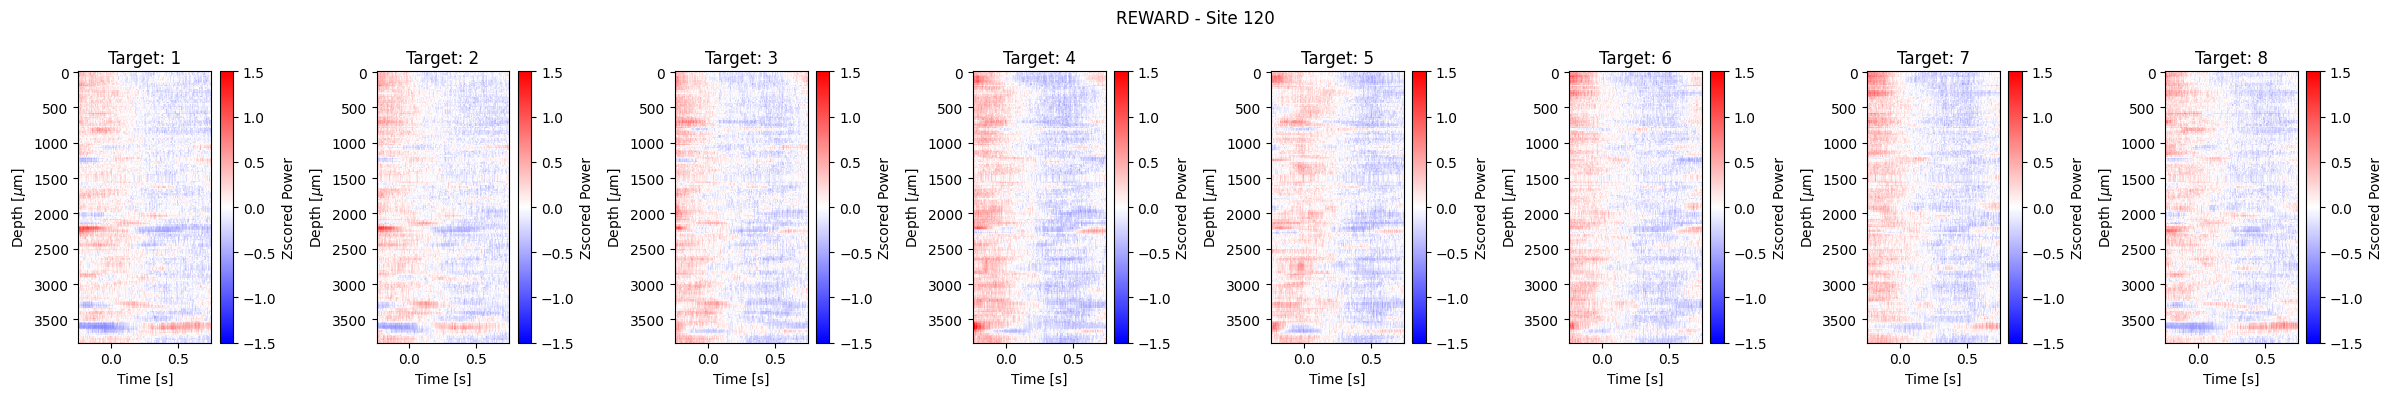

In [52]:
# Target specific figures. 
ntargets = len(np.unique(df_mc['target_idx']))-1
fig, ax = plt.subplots(1,ntargets,figsize=(ntargets*3,4))
for itarget in range(ntargets):
    target_idx_plot = np.where(np.array(df_mc['target_idx'][df_mc['reward']]) == (itarget+1))[0]
    map1 = ax[itarget].pcolor(t-tbefore, np.max(np.unique(metadata_mc['ypos'])) - np.unique(metadata_mc['ypos']), np.mean(((spec_mc[target_idx_plot,:,:] - np.mean(spec_mc[target_idx_plot,:,:],axis=(0,1)))/np.std(spec_mc[target_idx_plot,:,:], axis=(0,1))), axis=0).T, cmap='bwr', vmin=-1.5, vmax=1.5)
    cb = plt.colorbar(map1, label='Zscored Power')
    ax[itarget].invert_yaxis()
    ax[itarget].set(xlabel='Time [s]', ylabel='Depth [$\mu$m]', title=f"Target: {itarget+1}")
    
plt.suptitle(f"{task_event_to_align} - Site {site}")
fig.tight_layout()
aopy.visualization.savefig(base_save_dir, f"{subject}_Site{site}_mc_zpower_targets_{task_event_to_align}{mc_teid}.png")

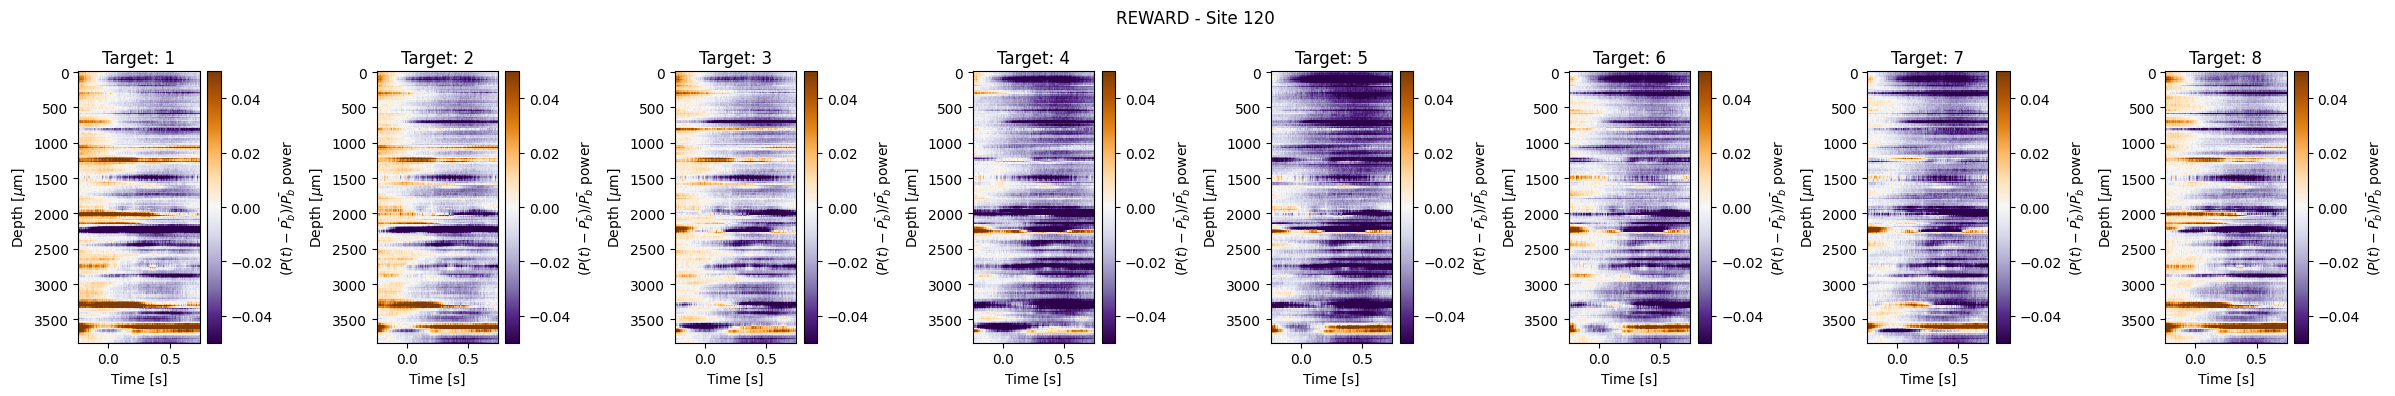

In [53]:
# Target specific figures. 
ntargets = len(np.unique(df_mc['target_idx']))-1
fig, ax = plt.subplots(1,ntargets,figsize=(ntargets*3,4))
for itarget in range(ntargets):
    target_idx_plot = np.where(np.array(df_mc['target_idx'][df_mc['reward']]) == (itarget+1))[0]
    bidx1 = 0
    bidx2 = np.where((t-tbefore)>=0)[0][0]
    map2 = ax[itarget].pcolor(t-tbefore,  np.max(np.unique(metadata_mc['ypos'])) - np.unique(metadata_mc['ypos']), ((np.mean(spec_mc, axis=0) - np.mean(spec_mc[target_idx_plot,:,:][:,bidx1:bidx2,:], axis=(0,1)))/np.mean(spec_mc[:,bidx1:bidx2,:], axis=(0,1))).T, cmap='PuOr_r', vmin=-0.05, vmax= 0.05)
    cb = plt.colorbar(map2, label=r'$(P(t) - \bar{P_b})/\bar{P_b}$ power')
    ax[itarget].invert_yaxis()
    ax[itarget].set(xlabel='Time [s]', ylabel='Depth [$\mu$m]', title=f"Target: {itarget+1}")
    
plt.suptitle(f"{task_event_to_align} - Site {site}")
fig.tight_layout()
aopy.visualization.savefig(base_save_dir, f"{subject}_Site{site}_mc_powerNorm_targets_{task_event_to_align}{mc_teid}.png")